![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

ms' new movie studio needs to decide on what type of films to create. by analyzing what films are currently performing well, the studio can focus its resources into films that are most likely to succeed. Using movie data from several sources, I examine how genre, runtime, and time of release affects a films return on investment.

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

This project uses data from several sources, such as IMDB (supplying runtime and genre), Box Office Mojo (supplying financial data), and The Numbers (supplying additional financial data, release date, and production budget). '10-'20

In [103]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [104]:
# Here you run your code to explore the data
imdb_basic = pd.read_csv('data/title.basics.csv')
imdb_ratings = pd.read_csv('data/title.ratings.csv')
bom_gross = pd.read_csv('data/bom.movie_gross.csv')
tn_budget = pd.read_csv('data/tn.movie_budgets.csv')

### "IMDB" data
Data from IMDB is used to determine a film's genre and runtime.

In [105]:
imdb_basic.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


### "Box Office Mojo" data
Data from Box Office Mojo is used for information regarding a film's financial performance.

In [106]:
bom_gross.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


### "The Numbers" data
Data from The Numbers is used to determine a film's production budget.

In [107]:
tn_budget.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

Data preparation steps are as follows:
* Create a new column using the film title and start year. Then, join the tables on that column.
* Since movie genre and financial performance are critical to this analysis, drop rows missing genre or financial data.
* Clean domestic & foreign gross data and create a total_gross column.
* Remove any duplicate movies
* Create a new column to capture return on investment (roi)
* Expand genres column to columns containing boolean values for each genre category
* To ensure results are not skewed, drop outliers based on financial data.
* Create new column for month of release


In [108]:
#create a column to join on
df = imdb_basic
#start with a clean movie title
df.loc[:, 'title_clean'] = (df['primary_title'].str.strip().str.lower())
bom_gross.loc[:, 'title_clean'] = (bom_gross['title'].str.strip().str.lower())
tn_budget.loc[:, 'title_clean'] = (tn_budget['movie'].str.strip().str.lower())

#then add release year

#have to clean tn release date first

def cleanDate(dateStr):
    date = datetime.strptime(dateStr, '%b %d, %Y')
    return str(date.year)


tn_budget.loc[:, 'year_clean'] = tn_budget['release_date'].map(cleanDate)

df.loc[:, 'title_year'] = (df['title_clean'] + df['start_year'].astype(str))
bom_gross.loc[:, 'title_year'] = (bom_gross['title_clean'] + bom_gross['year'].astype(str))
tn_budget.loc[:, 'title_year'] = (tn_budget['title_clean'] + tn_budget['year_clean'].astype(str))


df.set_index('title_year', inplace=True)
bom_gross.set_index('title_year', inplace=True)
tn_budget.set_index('title_year', inplace=True)

In [109]:
#join tables
df = df.join(bom_gross, how='left', rsuffix='_bom')
df = df.join(tn_budget, how='left', rsuffix='_tn')


In [110]:
#drop rows missing genre data
df.dropna(subset = ['genres'], inplace=True)
#drop rows missing financial data
df.dropna(subset=['domestic_gross_tn', 'domestic_gross'], how='all', inplace=True)
to_drop = df.loc[df['worldwide_gross'].isna() & (~df['domestic_gross'].isnull() & df['foreign_gross'].isnull())].index
df.drop(to_drop, inplace=True)

#df.isna().sum()

In [111]:
#clean gross data and create total_gross column

df.reset_index(inplace = True)

def cleanGross(gross):
    gross = str(gross)
    gross = gross.replace('$', '').replace(',', '')
    return float(gross)

df.loc[~df['worldwide_gross'].isnull(), 'total_gross'] = df['worldwide_gross'].map(cleanGross)
df['domestic_gross'] = df['domestic_gross'].map(cleanGross)
df['foreign_gross'] = df['foreign_gross'].map(cleanGross)
df.loc[df['total_gross'].isnull(), 'total_gross'] = df['domestic_gross'] + df['foreign_gross']
#df.isna().sum()

In [112]:
#remove duplicates using title_year column
df = df[~df[['title_year']].duplicated(keep=False)]
df['title_year'].duplicated().sum()

0

In [113]:
#create new column, return on investment (roi)

#need to clean this one, too
df['production_budget'] = df['production_budget'].map(cleanGross)

df.loc[~df['production_budget'].isnull(), 'roi'] = df['total_gross'] - df['production_budget']
#df[~df['roi'].isna()]

In [114]:
#get distinct genre categories
distinct_genres_raw = df['genres'].unique()

distinct_genres_clean = set()

for elem in distinct_genres_raw:
    elem = str(elem)
    elem = elem.strip()
    elem = elem.lower()
    genres = elem.split(',')
    for category in genres:
        distinct_genres_clean.add(category)
#distinct_genres_clean.remove('nan')

#add a column for each category containing a boolean value
for category in distinct_genres_clean:
    print(category)
    df.loc[(df['genres'].str.strip().str.lower().str.contains(category)), category] = True
    
#replace NaNs in new columns with false
for category in distinct_genres_clean:
    df[category].fillna(False, inplace=True)
    


thriller
music
documentary
adventure
romance
musical
animation
action
crime
sport
sci-fi
war
mystery
western
family
fantasy
horror
biography
history
comedy
drama


In [115]:
def getOutlierRange(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    
    return (lower_bound, upper_bound)

gross_out = getOutlierRange(df['total_gross'])
df_dropOutliers = df[~( (df['total_gross'] < gross_out[0]) | (df['total_gross'] > gross_out[1]) )]

roi_out = getOutlierRange(df_dropOutliers['roi'])
df_dropOutliers = df_dropOutliers[~( (df_dropOutliers['roi'] < roi_out[0]) | (df_dropOutliers['roi'] > roi_out[1]) )]

#df_dropOutliers

,title_year,tconst,primary_title,original_title,start_year,runtime_minutes,genres,title_clean,title,studio,domestic_gross,foreign_gross,year,title_clean_bom,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,title_clean_tn,year_clean,total_gross,roi,thriller,music,documentary,adventure,romance,musical,animation,action,crime,sport,sci-fi,war,mystery,western,family,fantasy,horror,biography,history,comedy,drama
0,#horror2015,tt3526286,#Horror,#Horror,2015,101.0,"Crime,Drama,Horror",#horror,NaN,NaN,NaN,NaN,NaN,NaN,16.0,"Nov 20, 2015",#Horror,1500000.0,$0,$0,#horror,2015,0.0,-1500000.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,10 cloverfield lane2016,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",10 cloverfield lane,10 Cloverfield Lane,Par.,72100000.0,38100000.0,2016.0,10 cloverfield lane,54.0,"Mar 11, 2016",10 Cloverfield Lane,5000000.0,"$72,082,999","$108,286,422",10 cloverfield lane,2016,108286422.0,103286422.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
2,10 days in a madhouse2015,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama,10 days in a madhouse,NaN,NaN,NaN,NaN,NaN,NaN,48.0,"Nov 11, 2015",10 Days in a Madhouse,12000000.0,"$14,616","$14,616",10 days in a madhouse,2015,14616.0,-11985384.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,102 not out2018,tt6580564,102 Not Out,102 Not Out,2018,102.0,"Comedy,Drama",102 not out,102 Not Out,Sony,1300000.0,10900000.0,2018.0,102 not out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12200000.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,11-11-112011,tt1712159,11-11-11,11-11-11,2011,90.0,"Horror,Mystery,Thriller",11-11-11,11-11-11,Rocket,32800.0,5700000.0,2011.0,11-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5732800.0,NaN,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,zipper2015,tt3346224,Zipper,Zipper,2015,112.0,"Drama,Thriller",zipper,NaN,NaN,NaN,NaN,NaN,NaN,57.0,"Aug 28, 2015",Zipper,4500000.0,$0,$0,zipper,2015,0.0,-4500000.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1898,zombie hunter2013,tt2446502,Zombie Hunter,Zombie Hunter,2013,93.0,"Action,Comedy,Horror",zombie hunter,NaN,NaN,NaN,NaN,NaN,NaN,16.0,"Oct 8, 2013",Zombie Hunter,1000000.0,$0,$0,zombie hunter,2013,0.0,-1000000.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False
1899,zookeeper2011,tt1222817,Zookeeper,Zookeeper,2011,102.0,"Comedy,Family,Romance",zookeeper,Zookeeper,Sony,80400000.0,89500000.0,2011.0,zookeeper,71.0,"Jul 8, 2011",Zookeeper,80000000.0,"$80,360,866","$170,805,525",zookeeper,2011,170805525.0,90805525.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1900,zoolander 22016,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,Comedy,zoolander 2,Zoolander 2,Par.,28800000.0,27900000.0,2016.0,zoolander 2,64.0,"Feb 12, 2016",Zoolander 2,50000000.0,"$28,848,693","$55,348,693",zoolander 2,2016,55348693.0,5348693.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [116]:
#create column for release month
def cleanMonth(dateStr):
    
    date = datetime.strptime(dateStr, '%b %d, %Y')
    return str(date.month)

#assign to new frame 
df_month = df_dropOutliers[~df_dropOutliers['release_date'].isna()]
df_month.loc[:, 'release_month'] = df_month['release_date'].map(cleanMonth)

C:\Users\Floobledorf\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Floobledorf\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

<AxesSubplot:>

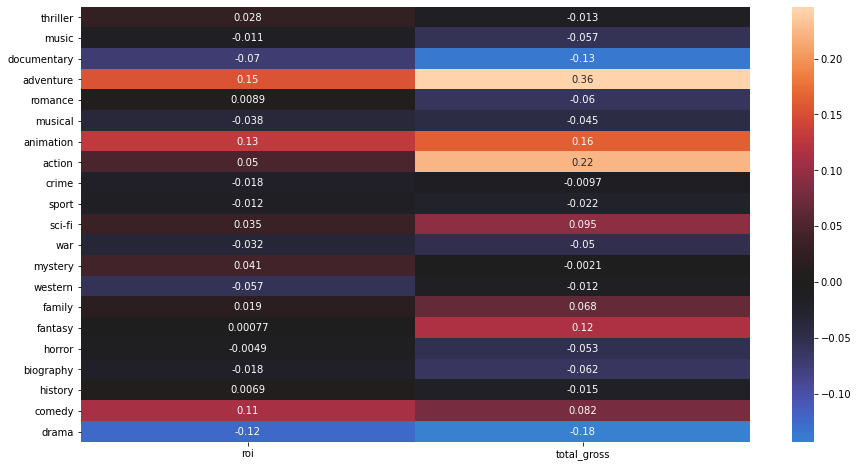

In [117]:

corr_col = ['thriller', 'music', 'documentary', 'adventure', 'romance', 'musical', 'animation', 
            'action', 'crime', 'sport', 'sci-fi', 'war', 'mystery', 'western', 'family', 'fantasy', 
            'horror', 'biography', 'history', 'comedy', 'drama', 
            'roi', 'total_gross']



plt.figure(figsize = (15,8))
df_corr = df_dropOutliers[corr_col].corr()[['roi', 'total_gross']]
df_corr.dropna(inplace=True)
df_corr.drop(['roi', 'total_gross'], inplace=True)
#df_corr.drop('total_gross', axis=1, inplace=True)
sns.heatmap(df_corr, center=0, robust=True, annot=True)
#df_dropOutliers.corr()

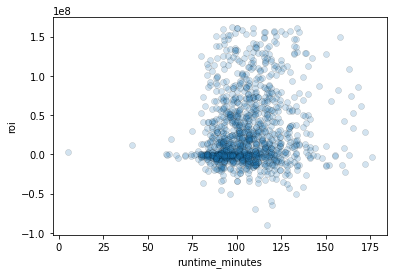

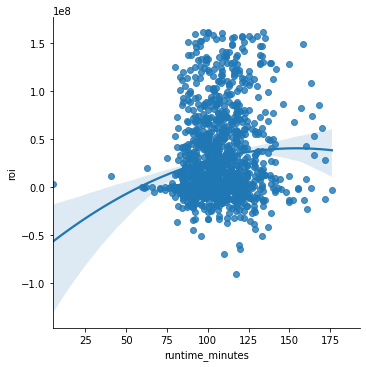

In [118]:
sns.scatterplot(x='runtime_minutes', y='roi', data=df_dropOutliers, alpha=0.2, edgecolor='k')

#sns.(x='runtime_minutes', y='roi', data=df_dropOutliers, alpha=1, edgecolor='k')
sns.lmplot(x='runtime_minutes', y='roi', data=df_dropOutliers, order=2)

<ipython-input-119-439e6e3367ae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runtime['runbins'] = pd.cut(df_dropOutliers['runtime_minutes'], bins).astype(str)


<AxesSubplot:xlabel='runbins', ylabel='roi'>

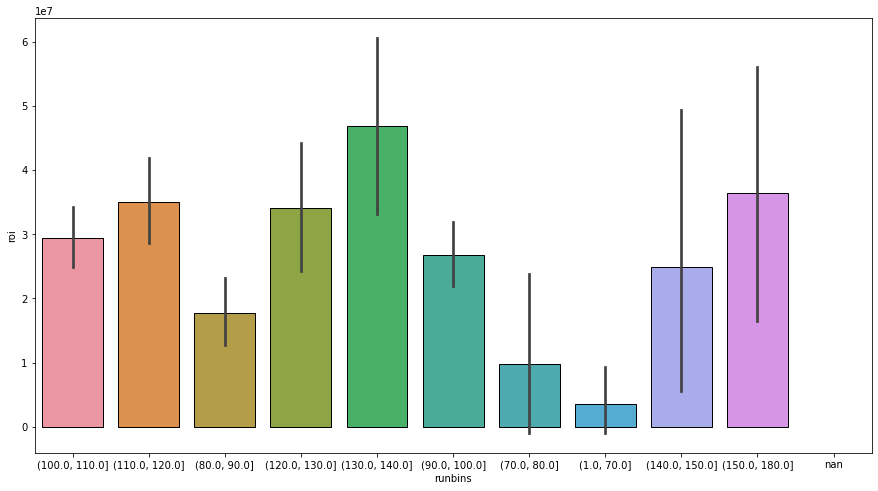

In [119]:
bins = [1, 70, 80, 90, 100, 110, 120, 130, 140, 150, 180]

#df_dropOutliers[['roi','runtime_minutes']].groupby(pd.cut(df_dropOutliers['runtime_minutes'], bins)).head()

#pd.cut(df_dropOutliers['runtime_minutes'], bins)

df_runtime = df_dropOutliers[~df_dropOutliers['runtime_minutes'].isna()]
df_runtime['runbins'] = pd.cut(df_dropOutliers['runtime_minutes'], bins).astype(str)
#df_runtime
plt.figure(figsize = (15,8))
sns.barplot(x='runbins', y='roi', data=df_runtime, alpha=1, edgecolor='k')
#sns.scatterplot(x='runtime_minutes', y='roi', data=df_dropOutliers, alpha=0.2, edgecolor='k')

Text(0.5, 1.0, 'release_month vs roi')

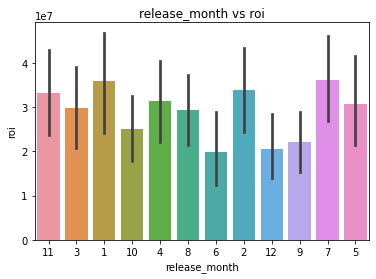

In [120]:
month_avgs = df_month[['roi', 'release_month']].groupby('release_month').mean()
month_avgs.rename(index={'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May',
                         '6': 'Jun', '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}, inplace=True)
sns.barplot(x='release_month', y='roi', data=df_month).set_title('release_month vs roi')

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***